In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data\\operations\\data.csv')

df.head()

,Well,Rig,Average ROP (m/hr),Average NPT (%),Days to Total Depth (d),Total Footage per Well (m),Well Tortuosity,Percent of Contact Footage (%),Tripping Speed (m/hr),Slip to Slip (min),Slip to Bottom (min),Bottom to Slip (min)
0,1,Rig 5,106.483157,6.491206,21.835820,9629.227260,13.913526,35.506137,1905.488394,12.854601,14.909235,11.963119
1,2,Rig 8,99.992847,8.182001,24.393615,8760.826340,15.479621,31.059074,1693.986392,14.155957,18.462595,16.309197
2,3,Rig 12,119.203696,6.527974,22.269004,8909.024064,9.343466,31.570173,1509.780749,12.927544,12.648343,12.995750
3,4,Rig 2,76.973312,7.309136,18.180496,9351.284832,12.714383,39.592657,1494.678735,5.587199,19.424256,5.883130
4,5,Rig 1,108.199212,7.275608,20.727467,9077.847949,14.243669,67.379470,1749.200780,8.172251,7.644439,2.404464


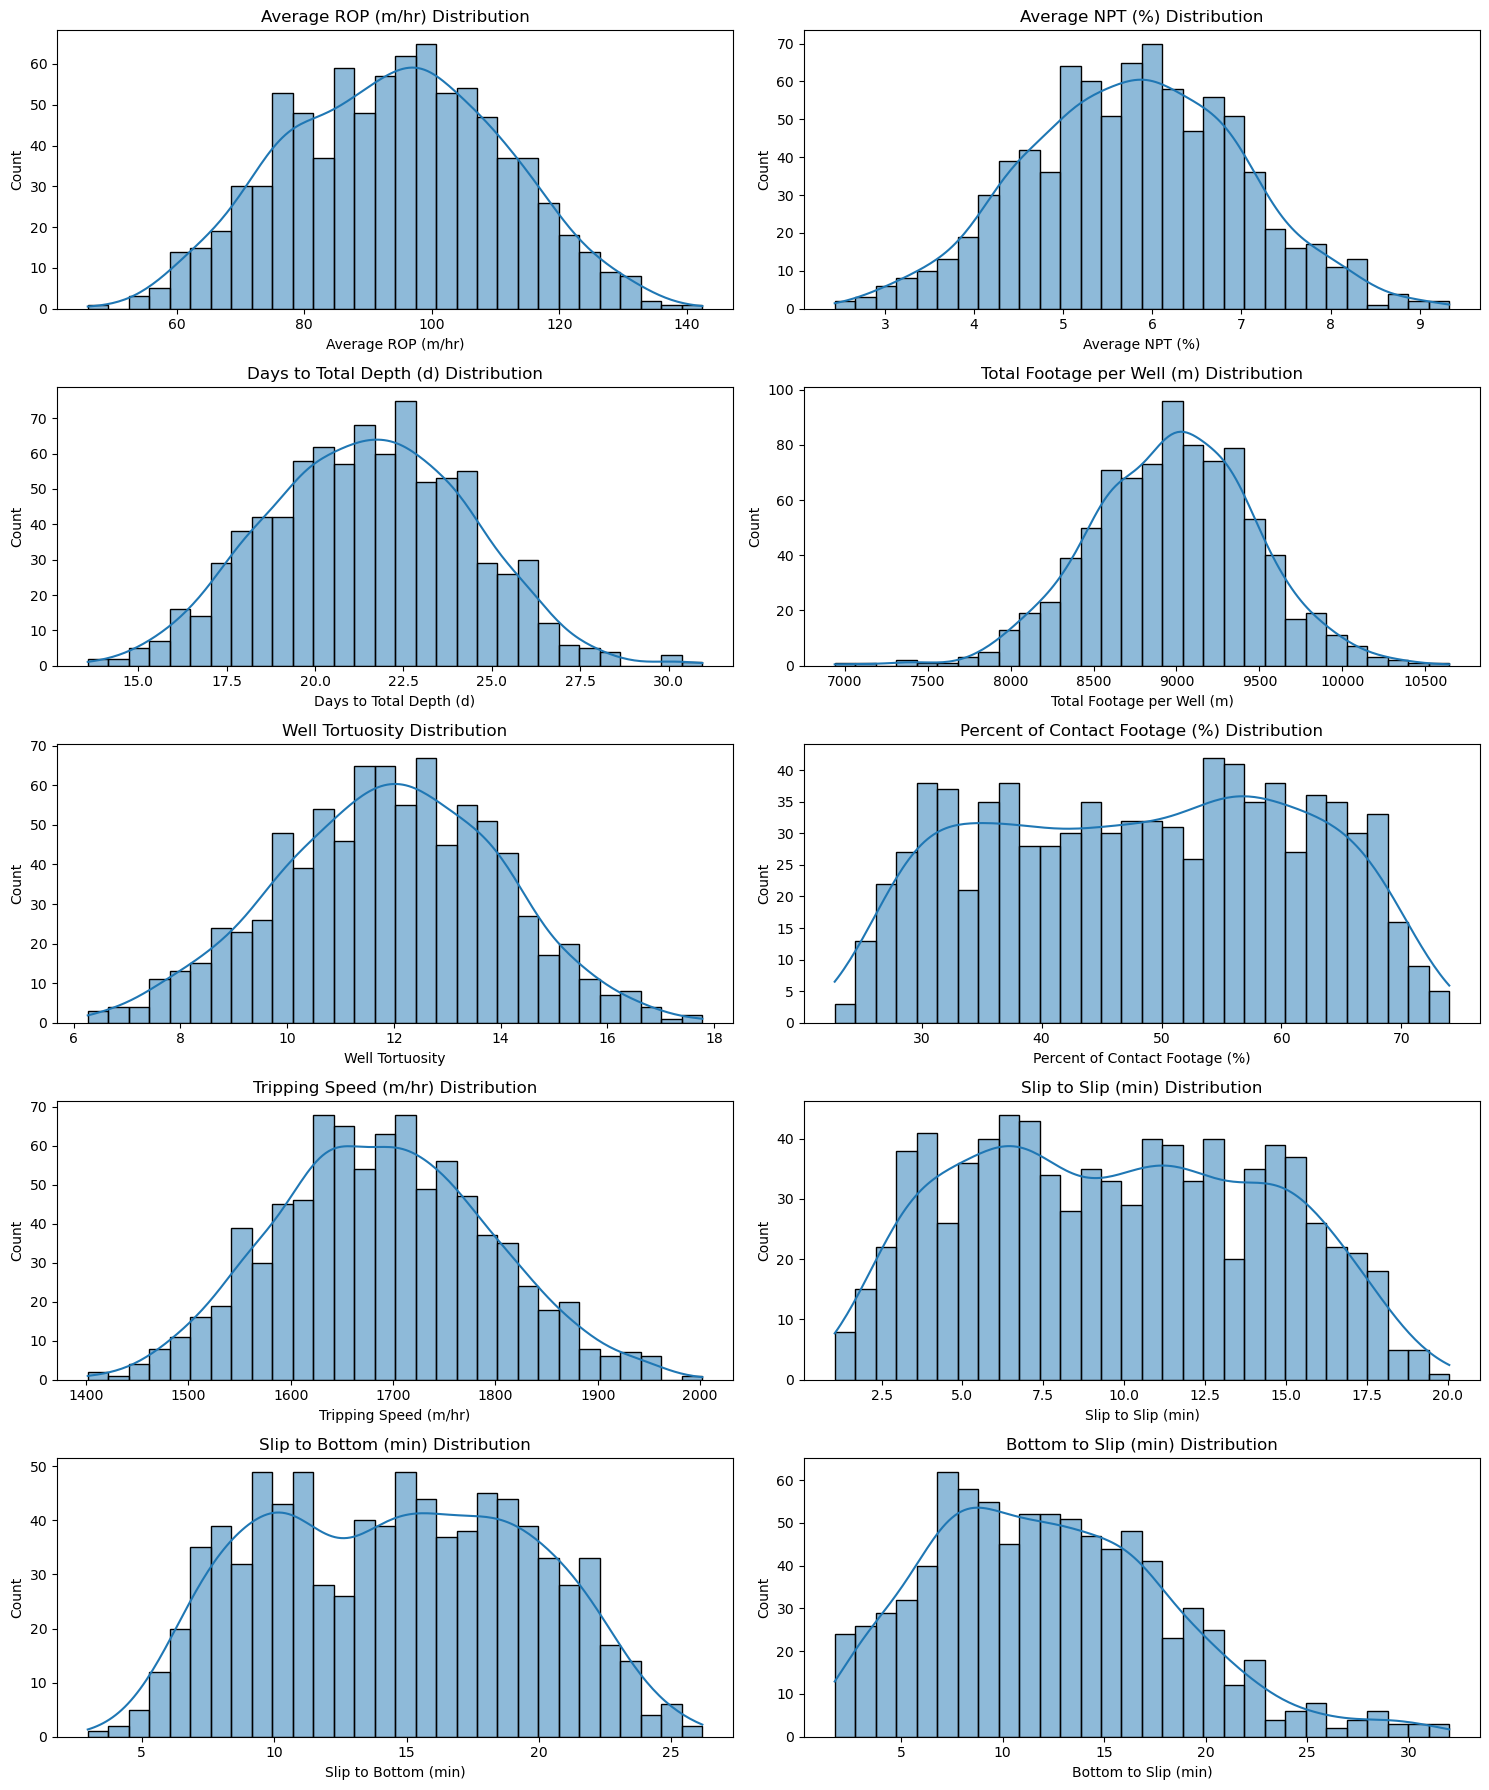

In [7]:
# Plot KDE distributions for each metric
plt.figure(figsize=(15, 18))
for i, column in enumerate(df.columns[2:]):  # Skip 'Well' and 'Rig'
    plt.subplot(5, 2, i+1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()


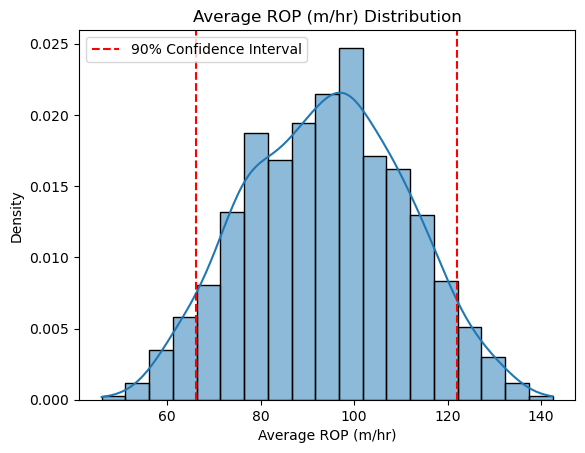

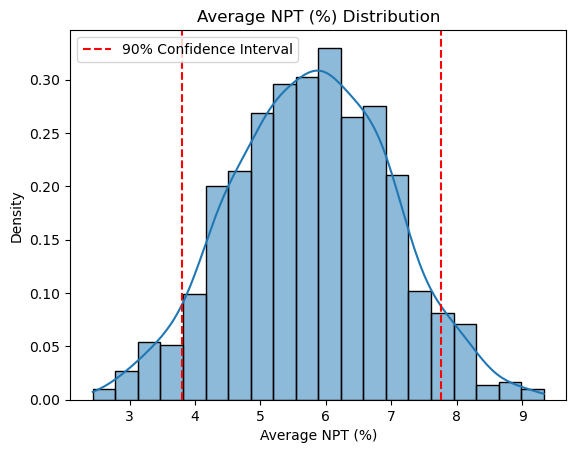

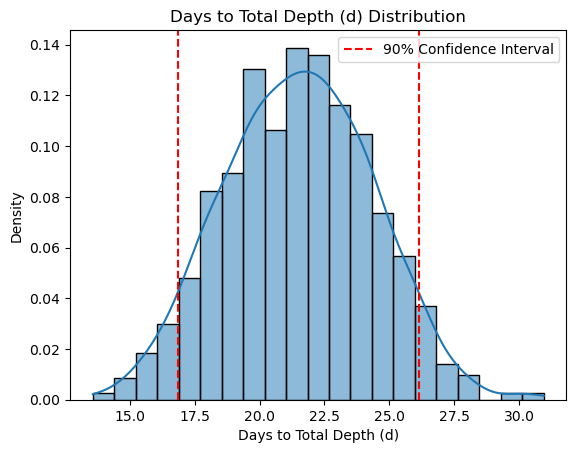

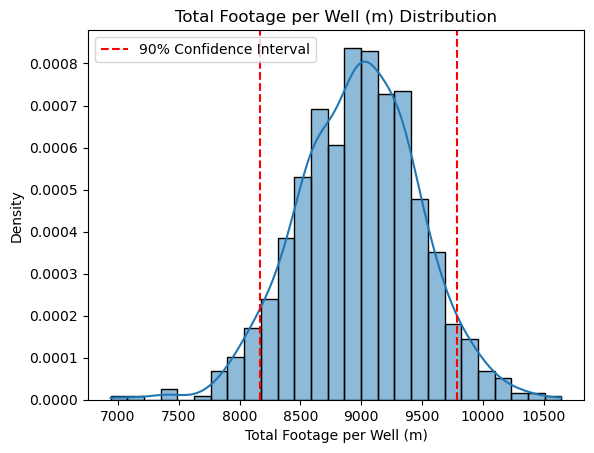

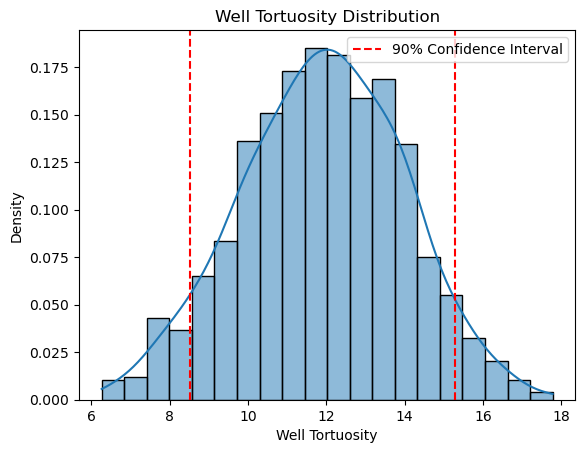

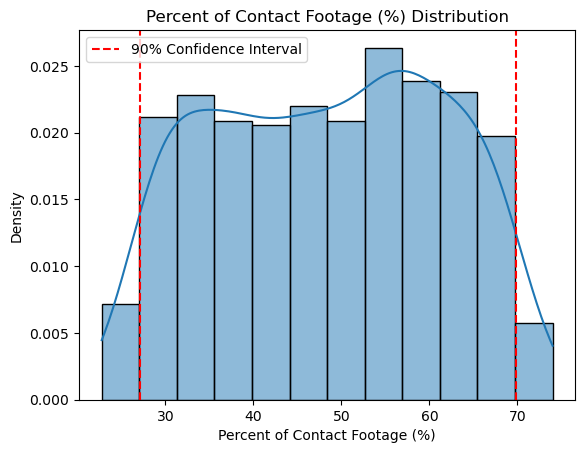

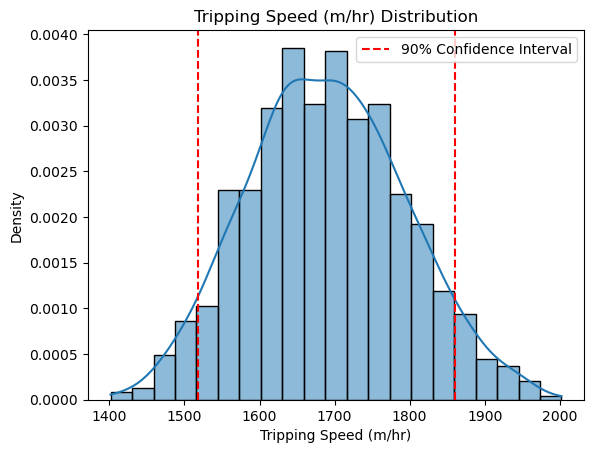

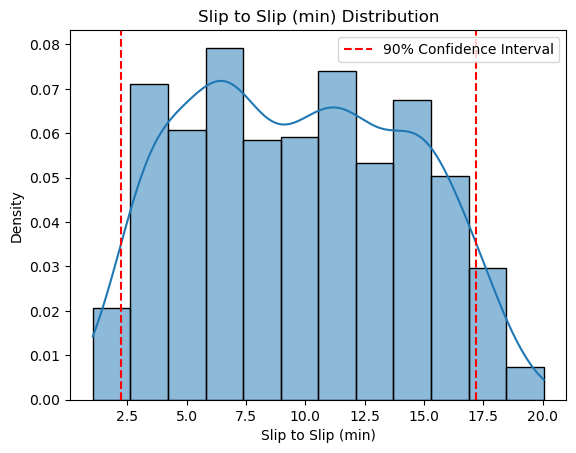

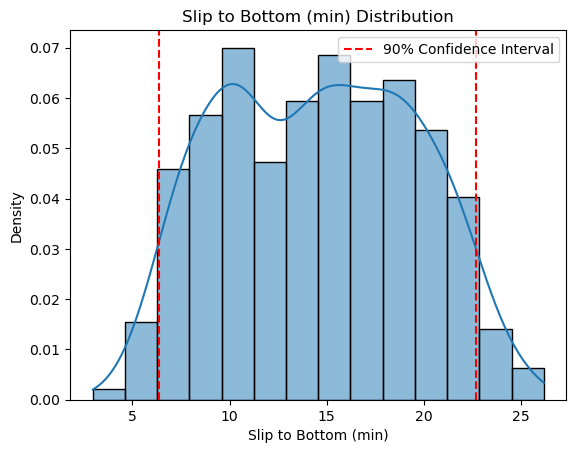

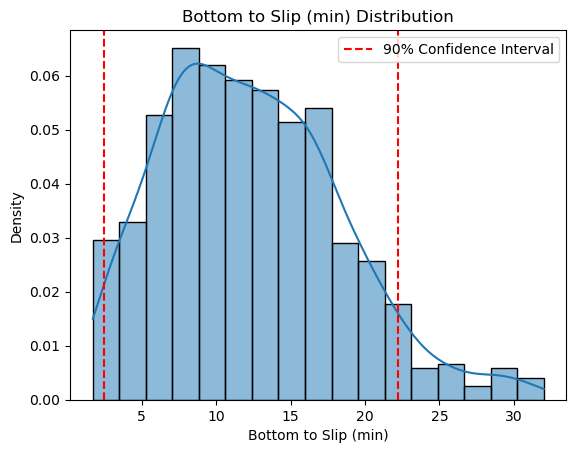

In [8]:
from scipy.stats import norm

# Generate the equivalent normal distribution for each KPI
for col in df.columns[2:]:
    mu, std = norm.fit(df[col])
    df[f'{col}_norm'] = norm(mu, std).pdf(df[col])

    # Calculate the 90% confidence interval for each KPI
    ci = norm.interval(0.9, loc=mu, scale=std)
    df[f'{col}_ci'] = ci[1] - ci[0]

    # Plot the distribution and confidence interval for each KPI
    fig, ax = plt.subplots()
    sns.histplot(df, x=col, kde=True, stat='density', ax=ax)
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.axvline(ci[0], color='r', linestyle='--', label='90% Confidence Interval')
    ax.axvline(ci[1], color='r', linestyle='--')
    ax.legend()
    plt.show()

In [14]:
def is_problematic(df, column, value):
    mu, std = norm.fit(df[column])

    # Calculate the 90% confidence interval
    ci = norm.interval(0.9, loc=mu, scale=std)

    # Check if the value is within the confidence interval
    if ci[0] <= value <= ci[1]:
        print(f'The value {value} is within the 90% confidence interval [{ci[0]:.2f}, {ci[1]:.2f}]')
        print("No")
        problematic=False
    else:
        print(f'The value {value} is not within the 90% confidence interval [{ci[0]:.2f}, {ci[1]:.2f}]')
        print("Yes")
        problematic=True
    return problematic

is_problematic(df,'Days to Total Depth (d)',24)

The value 24 is within the 90% confidence interval [16.86, 26.16]
No


False

In [18]:
is_problematic(df,'Days to Total Depth (d)',27)

The value 27 is not within the 90% confidence interval [16.86, 26.16]
Yes


True

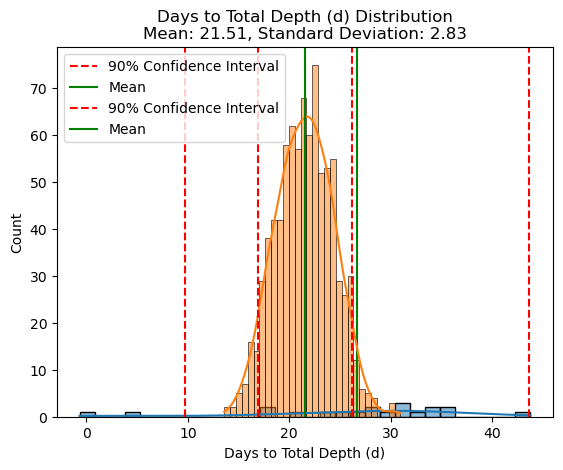

In [19]:
column = 'Days to Total Depth (d)'

df_new_rig = pd.read_csv('data/operations/days_to_total_depth_new_rig.csv')

df_new_rig.head()


sns.histplot(df_new_rig[column], kde=True, bins=30)

# Calculate the 90% confidence interval for each KPI
rig_mu, rig_std = norm.fit(df_new_rig['Days to Total Depth (d)'])
rig_ci = norm.interval(0.9, loc=rig_mu, scale=rig_std)

plt.title(f'{column} Distribution\nMean: {rig_mu:.2f}, Standard Deviation: {rig_std:.2f}')

# Plot the confidence interval for each KPI
plt.axvline(rig_ci[0], color='r', linestyle='--', label='90% Confidence Interval')
plt.axvline(rig_ci[1], color='r', linestyle='--')
plt.axvline(rig_mu, color='g', linestyle='-', label='Mean')
plt.legend()
sns.histplot(df[column], kde=True, bins=30)

# Calculate the 90% confidence interval for each KPI
field_mu, field_std = norm.fit(df['Days to Total Depth (d)'])
field_ci = norm.interval(0.9, loc=field_mu, scale=field_std)

plt.title(f'{column} Distribution\nMean: {field_mu:.2f}, Standard Deviation: {field_std:.2f}')

# Plot the confidence interval for each KPI
plt.axvline(field_ci[0], color='r', linestyle='--', label='90% Confidence Interval')
plt.axvline(field_ci[1], color='r', linestyle='--')
plt.axvline(field_mu, color='g', linestyle='-', label='Mean')
plt.legend()


Reject the null hypothesis - rig_mu is not smaller than field_mu


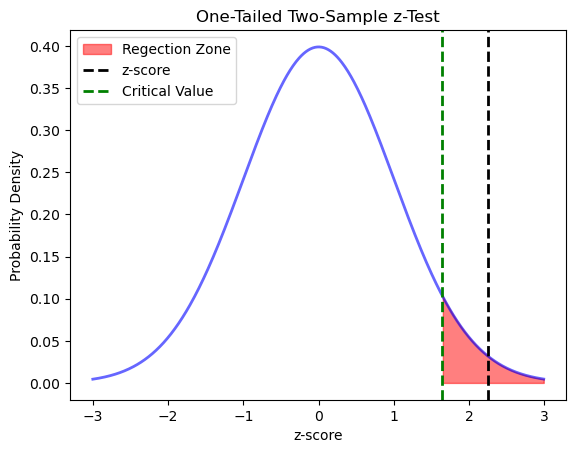

In [20]:
from scipy.stats import norm

rig_n = len(df_new_rig)
field_n = len(df)

# Calculate the test statistic
z = (rig_mu - field_mu) / ((rig_std**2 / rig_n) + (field_std**2 / field_n))**(1/2)

# Calculate the p-value
p_value = norm.sf(z)

# Set the significance level
alpha = 0.05

# Calculate the critical value
critical_value = norm.ppf(1 - alpha)

# Compare the test statistic to the critical value
if z > critical_value:
    print("Reject the null hypothesis - rig_mu is not smaller than field_mu")
else:
    print("Fail to reject the null hypothesis - rig_mu can be smaller than field_mu")
    
# Create a range of z-scores
z_range = np.arange(-3, 3, 0.01)

# Create a plot of the standard normal distribution
fig, ax = plt.subplots()
ax.plot(z_range, norm.pdf(z_range), 'b-', lw=2, alpha=0.6) # label='Standard Normal Distribution')

# Shade the area to the right of the critical value or the regection zone
ax.fill_between(z_range, 0, norm.pdf(z_range), where=z_range >= critical_value, color='red', alpha=0.5, label='Regection Zone')

# Add a vertical line for the test statistic
ax.axvline(x=z, color='black', linestyle='--', lw=2, label='z-score')

# Add a vertical line for the critical value
ax.axvline(x=critical_value, color='green', linestyle='--', lw=2, label='Critical Value')

# Add labels and a legend
ax.set_xlabel('z-score')
ax.set_ylabel('Probability Density')
ax.set_title('One-Tailed Two-Sample z-Test')
ax.legend(loc='best')

# Show the plot
plt.show()


NameError: name 'n' is not defined

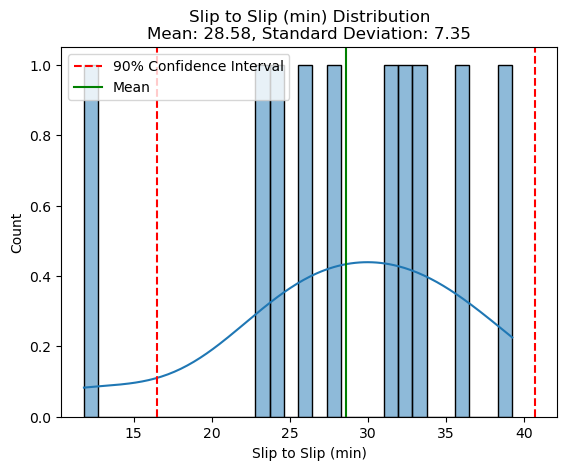

In [22]:
column = 'Slip to Slip (min)'

df_training = pd.read_csv('data/operations/after_training.csv')

df_training.head()

sns.histplot(df_training[column], kde=True, bins=30)

# Calculate the 90% confidence interval for each KPI
training_mu, training_std = norm.fit(df_training[column])
training_ci = norm.interval(0.9, loc=training_mu, scale=training_std)

plt.title(f'{column} Distribution\nMean: {training_mu:.2f}, Standard Deviation: {training_std:.2f}')

# Plot the confidence interval for each KPI
plt.axvline(training_ci[0], color='r', linestyle='--', label='90% Confidence Interval')
plt.axvline(training_ci[1], color='r', linestyle='--')
plt.axvline(training_mu, color='g', linestyle='-', label='Mean')
plt.legend()


training_n = len(df_training)

#H0: Xt - X = 0
#Ha: Xt - X < 0

alpha = 0.05
df = n + m - 2
cv = t.ppf(alpha, df)

t_stat = (training_mu - field_mu) / math.sqrt((field_std**2/field_n) + (training_std**2/training_n))

print(f"After Training: mu {training_mu:.2f}, std {training_std:.2f}")
print(f"Field data: mu {field_mu:.2f}, std {field_std:.2f}")

if t_stat < cv:
    print("Reject the null hypothesis. Training and field time are not the same")
else:
    print("Fail to reject the null hypothesis.Training and field time can be the same.")

# Plot the distribution and the rejection zone
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)
plt.plot(x, y, 'b-', linewidth=2)
plt.axvline(x=cv, color='r', linestyle='--')
plt.fill_between(x[x<=cv], y[x<=cv], color='r', alpha=0.5)
plt.axvline(x=t_stat, color='g', linestyle='--')
plt.title('t-Distribution with Degrees of Freedom = ' + str(df))
plt.xlabel('t-Value')
plt.ylabel('Probability Density')
plt.show()


After Training: mu 28.58, std 7.35
Field data: mu 30.00, std 5.00
Fail to reject the null hypothesis. Training and field time can be the same.


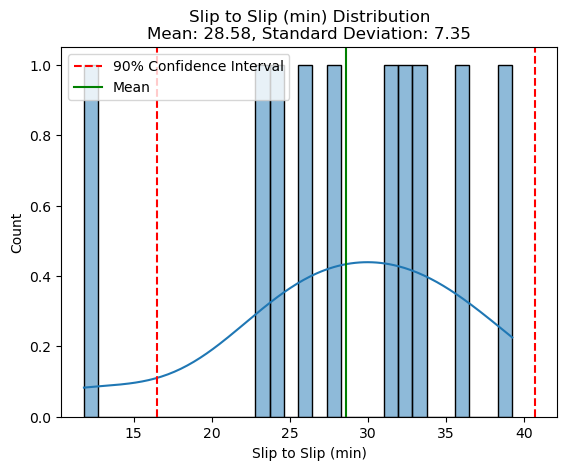

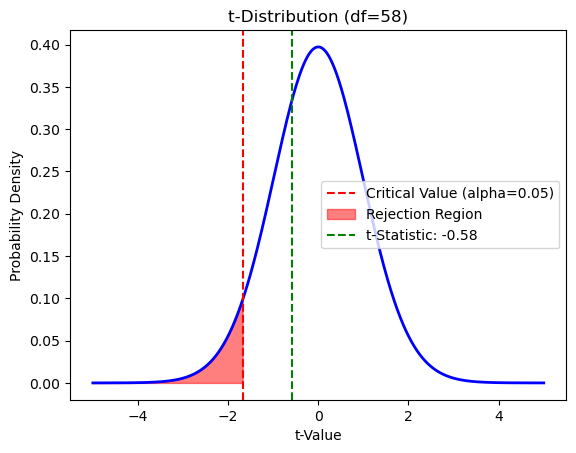

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t
import math

# Ensure field data variables are defined (use actual values or load field data)
field_mu = 30  # Example mean for field data
field_std = 5  # Example standard deviation for field data
field_n = 50   # Example sample size for field data

# Load training data
df_training = pd.read_csv('data/operations/after_training.csv')

# Define the column for analysis
column = 'Slip to Slip (min)'

# Plot the distribution with KDE (Kernel Density Estimate)
sns.histplot(df_training[column], kde=True, bins=30)

# Calculate the 90% confidence interval for the training data
training_mu, training_std = norm.fit(df_training[column])
training_ci = norm.interval(0.9, loc=training_mu, scale=training_std)

# Add title and confidence interval lines to the plot
plt.title(f'{column} Distribution\nMean: {training_mu:.2f}, Standard Deviation: {training_std:.2f}')
plt.axvline(training_ci[0], color='r', linestyle='--', label='90% Confidence Interval')
plt.axvline(training_ci[1], color='r', linestyle='--')
plt.axvline(training_mu, color='g', linestyle='-', label='Mean')
plt.legend()

# Sample size of the training data
training_n = len(df_training)

# Hypothesis test setup
alpha = 0.05
df = field_n + training_n - 2  # Degrees of freedom for two-sample t-test
cv = t.ppf(alpha, df)  # Critical value for left-tailed test

# Calculate the t-statistic for the difference in means
t_stat = (training_mu - field_mu) / math.sqrt((field_std**2 / field_n) + (training_std**2 / training_n))

# Print summary of results
print(f"After Training: mu {training_mu:.2f}, std {training_std:.2f}")
print(f"Field data: mu {field_mu:.2f}, std {field_std:.2f}")

# Hypothesis test decision
if t_stat < cv:
    print("Reject the null hypothesis. Training and field time are not the same.")
else:
    print("Fail to reject the null hypothesis. Training and field time can be the same.")

# Plot the t-distribution and the rejection region
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)
plt.figure()
plt.plot(x, y, 'b-', linewidth=2)
plt.axvline(x=cv, color='r', linestyle='--', label='Critical Value (alpha=0.05)')
plt.fill_between(x[x <= cv], y[x <= cv], color='r', alpha=0.5, label='Rejection Region')
plt.axvline(x=t_stat, color='g', linestyle='--', label=f't-Statistic: {t_stat:.2f}')
plt.title(f't-Distribution (df={df})')
plt.xlabel('t-Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()
